# KSP RocketPy
## What is this?
A handy notebook for teams to use in running basic rocketpy simulations.

Much of it is based on the [rocketpy readme](https://github.com/Projeto-Jupiter/RocketPy#readme), and the [user guide](https://docs.rocketpy.org/en/latest/notebooks/getting_started.html).

## Using KSP RocketPy
Simply import the module folder and required classes

In [6]:
try: from rocketpy import Environment, Rocket, SolidMotor, Flight, __version__
except ModuleNotFoundError:
    %pip install ipywidgets netCDF4 timezonefinder windrose simplekml
    from rocketpy import Environment, Rocket, SolidMotor, Flight, __version__

# Display the rocketpy used (ours is fork, the main is 0.12)
print(__version__)

0.12.0 - Fork


## Help Text
To access the documentation directly, use the inbuilt help python function.

In [7]:
help(Rocket.addFins)

Help on function addFins in module rocketpy.Rocket:

addFins(self, *args, **kwargs)
    See Rocket.addTrapezoidalFins for documentation.
    This method is set to be deprecated in version 1.0.0 and fully removed
    by version 2.0.0. Use Rocket.addTrapezoidalFins instead. It keeps the
    same arguments and signature.



## Basic Simulation Runthrough

### Setup an environment for the simulation
This includes the date, time, weather data, launch site coordinates and launch rail length. The current pad used is [here](https://goo.gl/maps/2g3hUcQDZmZLK47N6) on the Machrihanish Range.

In [8]:
from datetime import date

today = date.today()

# The launch coords
longitude = -5.680270
latitude = 55.433159

print(f"http://maps.google.com/maps?q={latitude},{longitude}")

Env = Environment(
    railLength=4,
    latitude=latitude,
    longitude=longitude,
    elevation=40,
    date=(today.year, today.month, today.day, 12) # Launch today at 12:00
) 

http://maps.google.com/maps?q=55.433159,-5.68027


We can then create an atmospheric model for use in our flight simulation

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-10-23 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 40.0 m


Atmospheric Model Details

Atmospheric Model Type: StandardAtmosphere
StandardAtmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1008.45 hPa
Surface Temperature: 287.89 K
Surface Air Density: 1.220 kg/m³
Surface Speed of Sound: 340.13 m/s


Atmospheric Model Plots


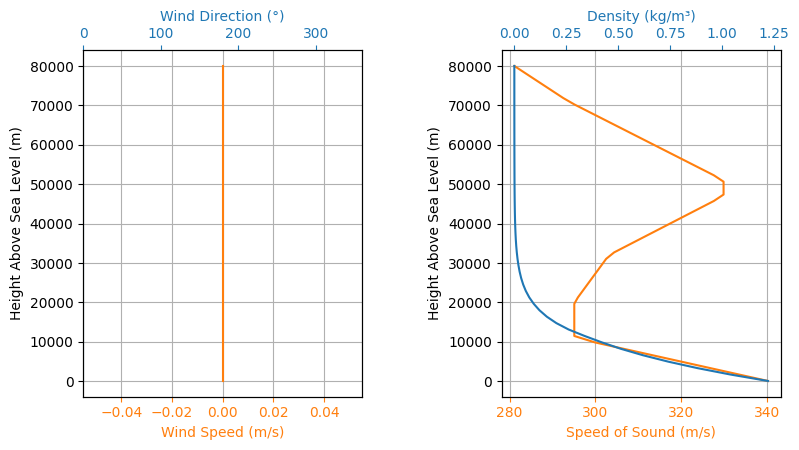

In [9]:
Env.setAtmosphericModel(
    type="StandardAtmosphere"
)
Env.info()

Alternativelt we can also get weather data from the [National Weather Service](https://nomads.ncep.noaa.gov/). Note that if the provided date for the environment is beyond the range of the forecasts, a `ValueError` is produced.

In [10]:
# Env.setAtmosphericModel(type='Forecast', file='GFS', dictionary='NOAA')
# Env.info()

### Setup a rocket motor
The motor used is the [Cesaroni M1450](https://www.thrustcurve.org/motors/Cesaroni/9955M1450-P/) as will be present on Nebula.

In [11]:
CesaroniM1450 = SolidMotor(
    thrustSource="data/motors/Cesaroni_9955M1450-P.eng",
    burnOut=6.9,
    grainNumber=1,
    grainDensity=12, # change later
    grainOuterRadius= 0.07, # change later
    grainInitialInnerRadius= 0.01,
    grainInitialHeight=0.4
)

### Setup the rocket itself
The parameters for the rocket motor, mass, drag profiles etc. (Note: this is not yet updated from Callisto)

#### Components and Centroids:

| Component                      | Centroid (m) | Weight (Kg) |
|--------------------------------|--------------|-------------|
| Nosecone                       | 1.550        | 0.089       |
| Deployment System              | 1.535        | 3.000       |
| Parachute                      | 1.245        | 0.879       |
| Parachute Section Airframe     | 1.255        | 0.100       |
| Avionics                       | 0.955        | 1.000       |
| Engine (Cesaroni 1450M, Total) | 0.440        | 8.578       |
| Engine Propellant              | 0.440        | 4.830       |
| Engine Airframe                | 0.43         | 3.600       |
| Stringer (x3)                  | 0.67         | 0.650       |
| Fins (x4)                      | 0.28         | 1.400       |
| Skirt                          | 0.078        | 0.092       |

#### Center

| State        | Center of Mass (m) | Mass (Kg) |
|--------------|--------------------|-----------|
| Rocket Full  | 0.774              | 24.888    |
| Rocket Empty | 0.871              | 20.058    |

In [12]:
NEBULA_RADIUS = 0.0725
NEBULA_TAIL_TAPER_RADIUS = 0.06
NEBULA_TAIL_LENGTH = 0.08

NEBULA_UNLOADED_CM = 0.871
NEBULA_UNLOADED_MASS = 14.558

NEBULA_LOADED_CM = 0.774
NEBULA_LOADED_MASS = 19.388

NOSE_CONE_CM = 1.550
NOSE_CONE_LENGTH = 0.435
NOSE_CONE_TYPE = "lvhaack"

NO_FINS = 4
FINS_CM = 0.28
FINS_MASS = 0.648
FIN_ROOT_CHORD = 0.29
FIN_TIP_CHORD = 0.080
FIN_SPAN = 0.100

In [13]:
Nebula = Rocket(
    motor=CesaroniM1450,
    radius=NEBULA_RADIUS,
    mass=NEBULA_UNLOADED_MASS,
    inertiaI=4.98,
    inertiaZ=0.0766,
    distanceRocketNozzle=-NEBULA_UNLOADED_CM,
    distanceRocketPropellant=-NEBULA_LOADED_CM,
    powerOffDrag='data/nebula/powerOffDragCurve.csv',
    powerOnDrag='data/nebula/powerOnDragCurve.csv'
)

We also add rail buttons (small wheels connected to the launch rail to guide the rocket)

In [14]:
Nebula.setRailButtons([0.2, -0.5]) # (PLEASE UPDATE) rail button positions (relatiuve to center of mass)

A nose cone, providing the distance to the center of mass and type. 
It is added to the list of aerodynamic surfaces used for simulation.

In [15]:
NoseCone = Nebula.addNose(length=NOSE_CONE_LENGTH, kind=NOSE_CONE_TYPE, distanceToCM=NOSE_CONE_CM-NEBULA_UNLOADED_CM)

Create fins, adding them to the list of aerodynamic surfaces

For nebula we have 4 equally spaced fins, of the design

In [16]:
FinSet = Nebula.addFins(4, span=FIN_SPAN, rootChord=FIN_ROOT_CHORD, tipChord=FIN_TIP_CHORD, distanceToCM=FINS_CM-NEBULA_UNLOADED_CM)

Add a tail/rocket diameter change

In [17]:
Tail = Nebula.addTail(topRadius=NEBULA_RADIUS, bottomRadius=NEBULA_TAIL_TAPER_RADIUS, length=NEBULA_TAIL_LENGTH, distanceToCM=NEBULA_TAIL_LENGTH-NEBULA_UNLOADED_CM)

Inertia Details
Rocket Mass: 14.558 kg (No Propellant)
Rocket Mass: 14.630 kg (With Propellant)
Rocket Inertia I: 4.980 kg*m2
Rocket Inertia Z: 0.077 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.0725 m
Rocket Frontal Area: 0.016513 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -0.871 m
Rocket Center of Mass - Motor reference point: -0.774 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.004 m

Aerodynamic Components Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 4.760/rad
Tail Lift Coefficient Derivative: -0.630/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 0.924 m
Fins Center of Pressure to CM: -0.727 m
Tail Center of Pressure to CM: -0.830 m
Distance - Center of Pressure to CM: -0.178 m
Initial Static Margin: 1.202 c
Final Static Margin: 1.228 c

Mass Plots


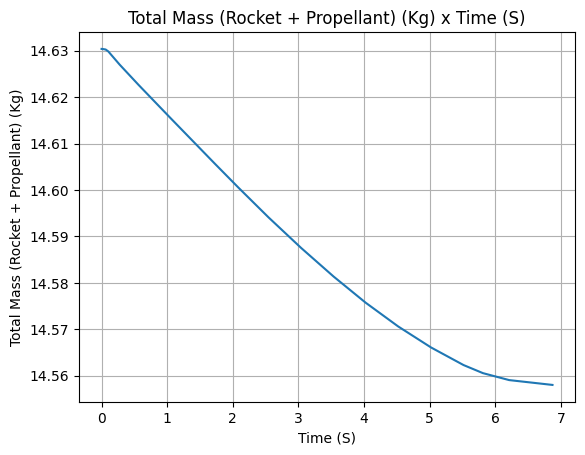

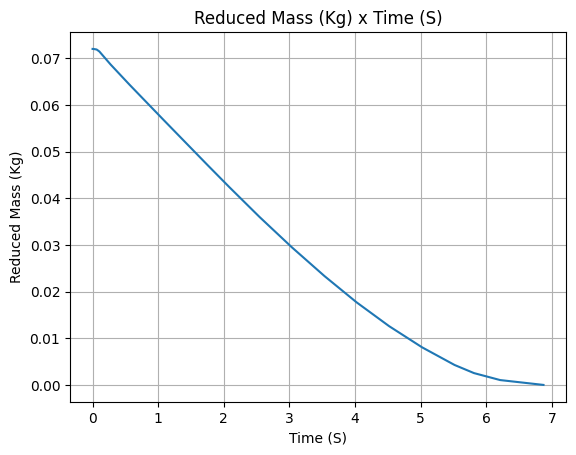


Aerodynamics Plots


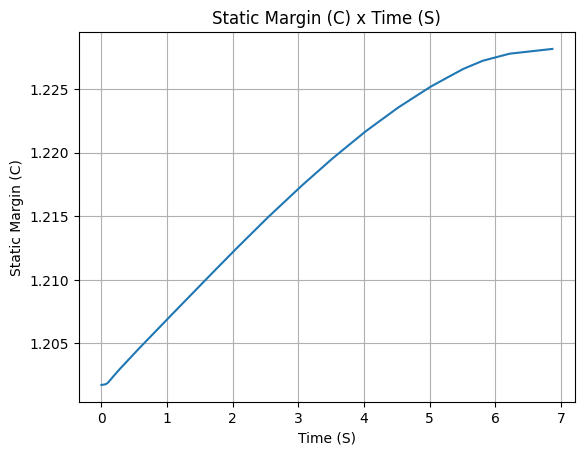

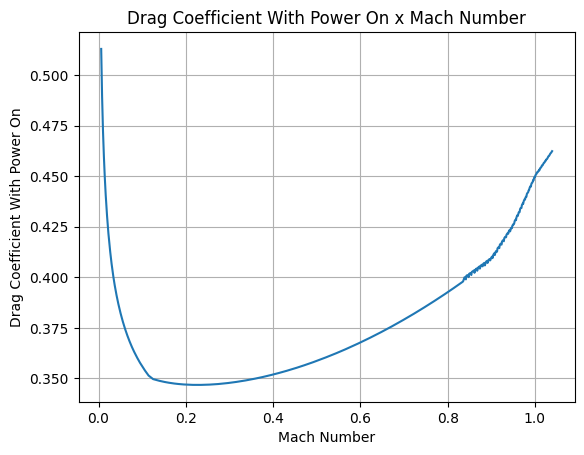

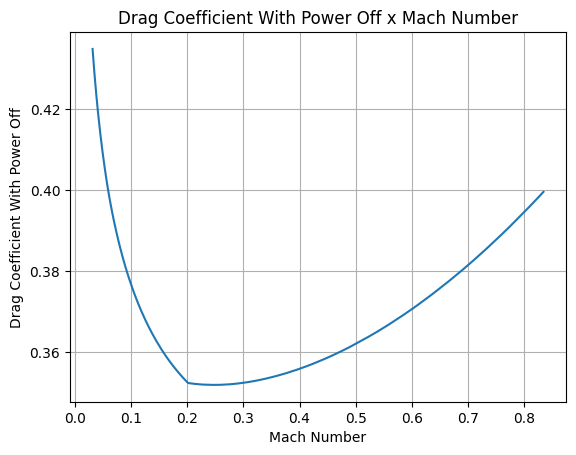

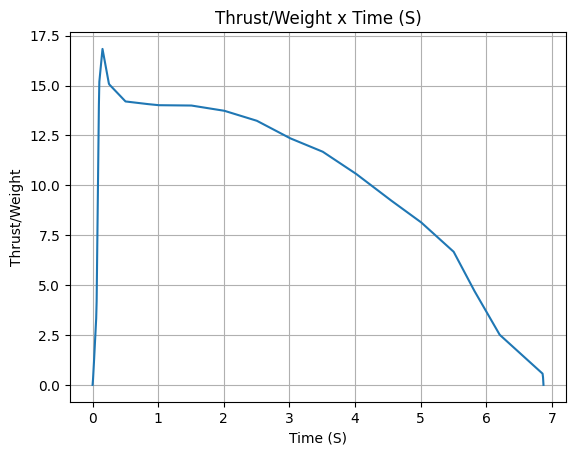

In [18]:
Nebula.allInfo()

### Setup Recovery
Adding parachutes, including multiple stages

We can define triggers parachutes, in terms of functions using pressure and the rocket's state vector. For example we can define a trigger for the drogue and main parachute.

Pending updates from recovery, no chutes are used in this simulation.

In [19]:
"""
Trigger functions are of type trigger(p,y) -> bool

where

p: pressure in pascal
y: state vector [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
"""

# Parachute deploy trigger
def deployTrigger(p, y):
    return y[5] < -10

# Parachute reef trigger
def disReefTrigger(p, y):
    return False

We can then use these functions as triggers to add parachutes to the rocket.

In [20]:
Reefed = Nebula.addParachute('Reefed',
                              CdS=0.3, # (PLEASE UPDATE) Drag coefficient times reference area for parachute
                              trigger=deployTrigger, 
                              samplingRate=105,
                              lag=1.5, # (PLEASE UPDATE) time taken from start to deployment
                              noise=(0, 8.3, 0.5))

Main = Nebula.addParachute('Disreefed',
                            CdS=1.0, # (PLEASE UPDATE) Drag coefficient times reference area for parachute
                            trigger=disReefTrigger, 
                            samplingRate=105,
                            lag=1.5, # (PLEASE UPDATE) time taken to reef
                            noise=(0, 8.3, 0.5))

## Run Simulation
Instantiating the `Flight` class runs the simulation, and generates data required for analysis.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 40.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 0.272 s
Rail Departure Velocity: 28.911 m/s
Rail Departure Static Margin: 1.203 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 14.994
Rail Departure Reynolds Number: 2.860e+05


BurnOut State

BurnOut time: 6.870 s
Altitude at burnOut: 2106.938 m (AGL)
Rocket velocity at burnOut: 398.889 m/s
Freestream velocity at burnOut: 398.889 m/s
Mach Number at burnOut: 1.203
Kinetic energy at burnOut: 1.158e+06 J


Apogee

Ap

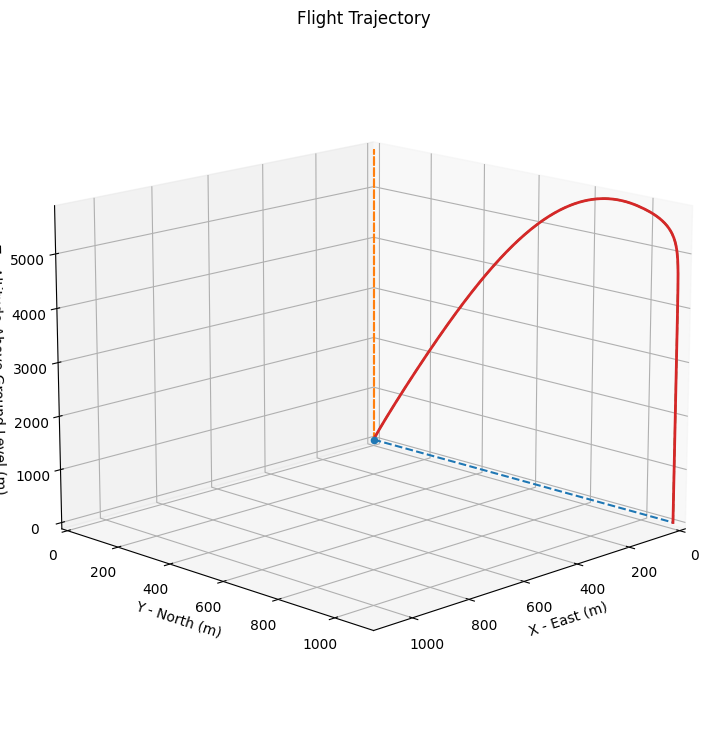



Trajectory Kinematic Plots



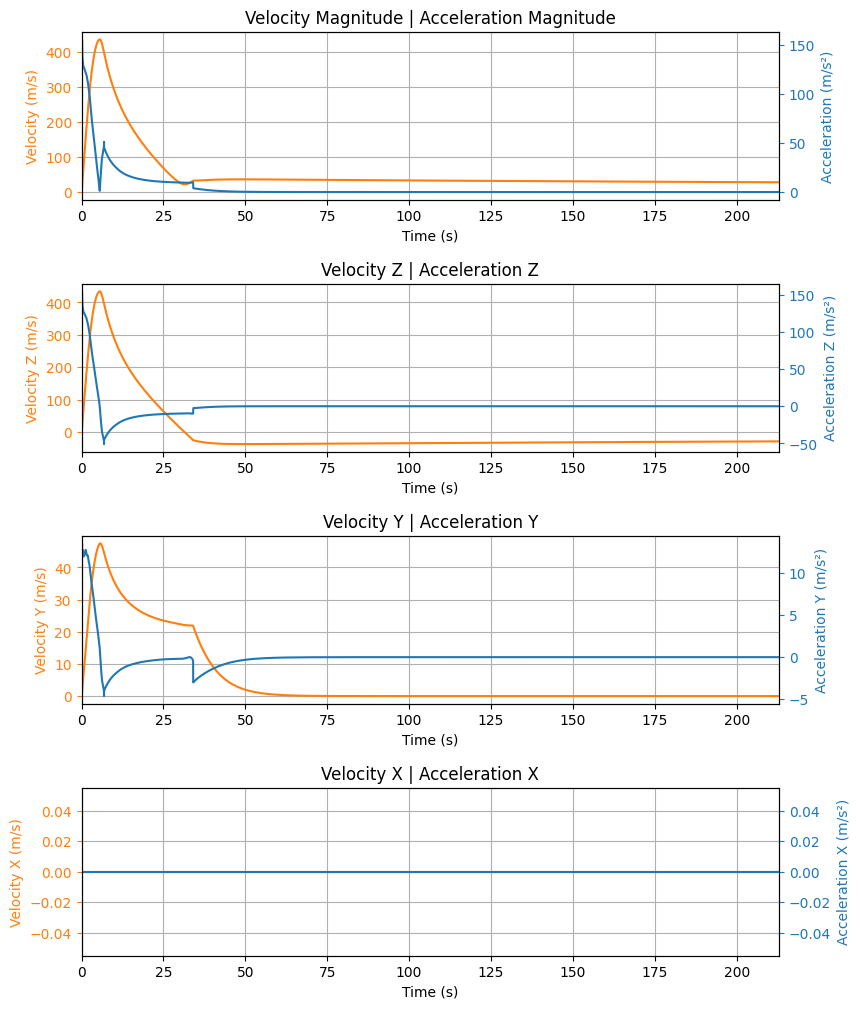



Angular Position Plots



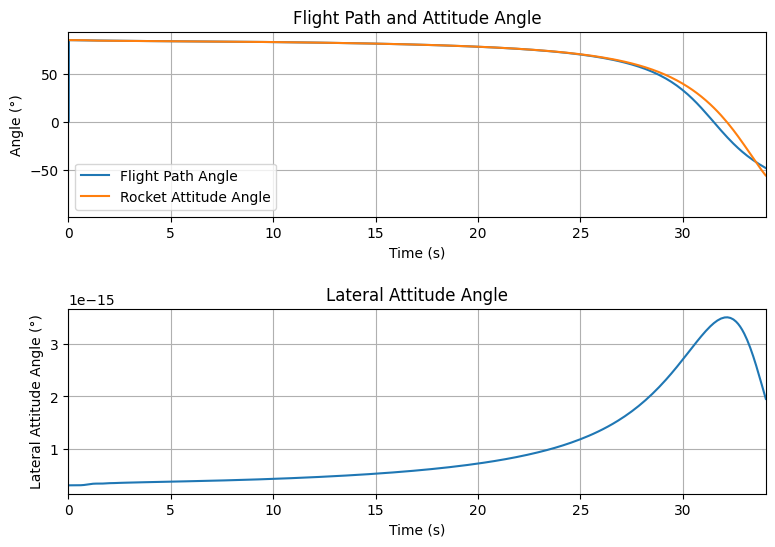



Path, Attitude and Lateral Attitude Angle plots



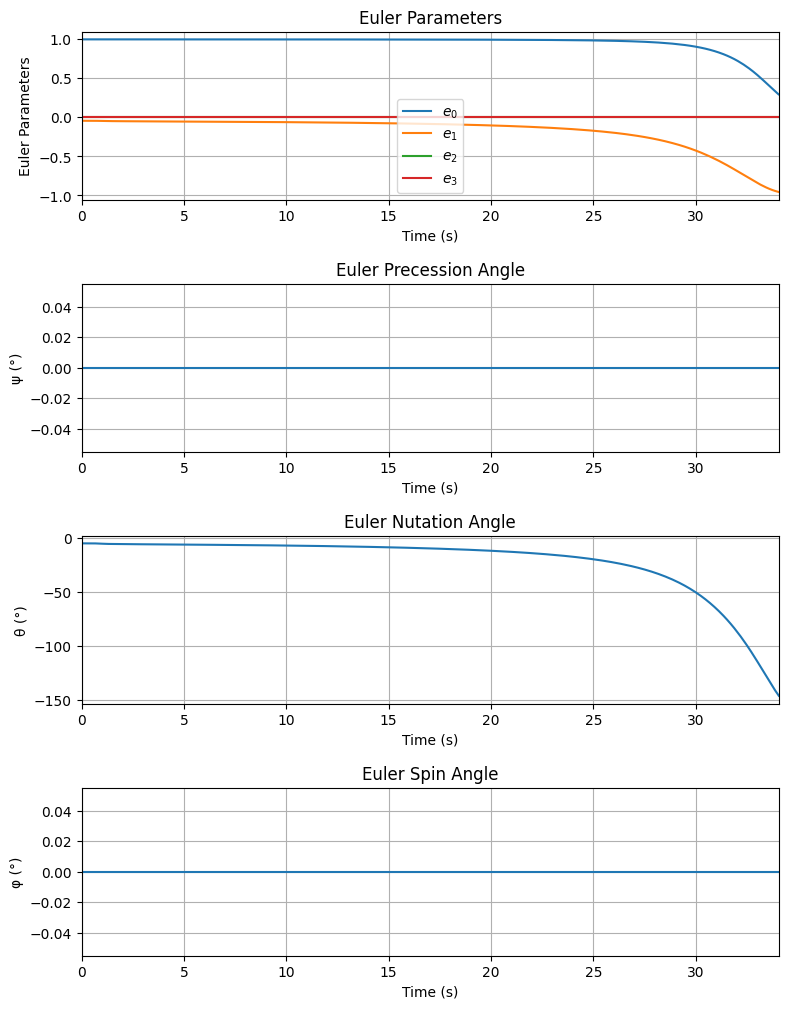



Trajectory Angular Velocity and Acceleration Plots



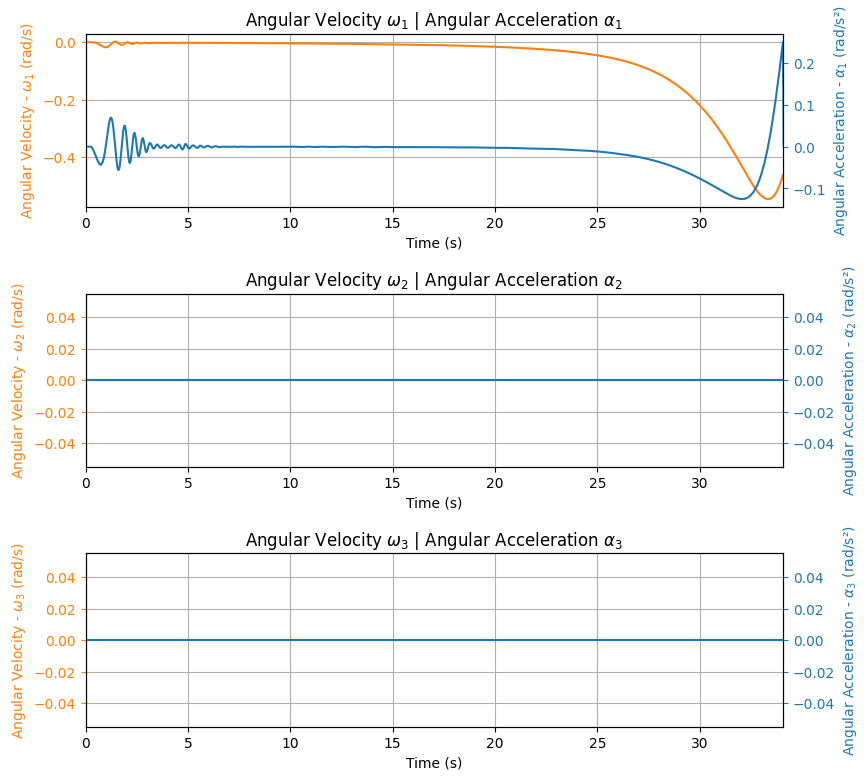



Trajectory Force Plots



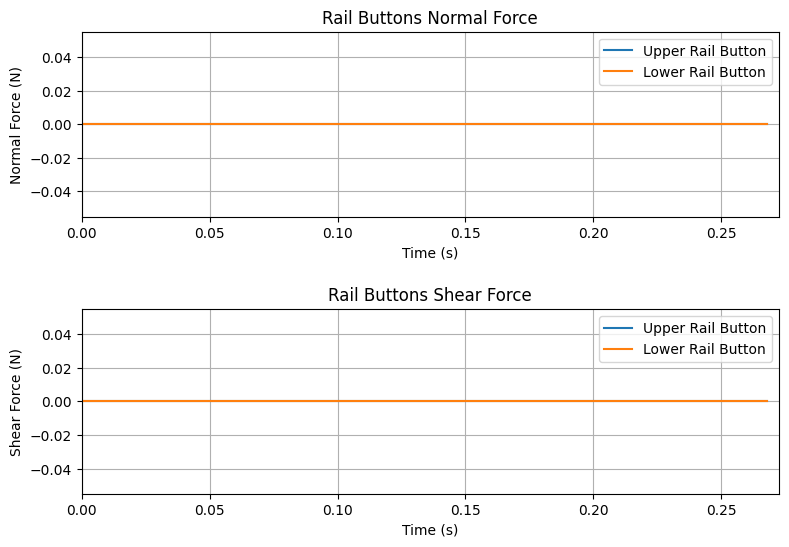

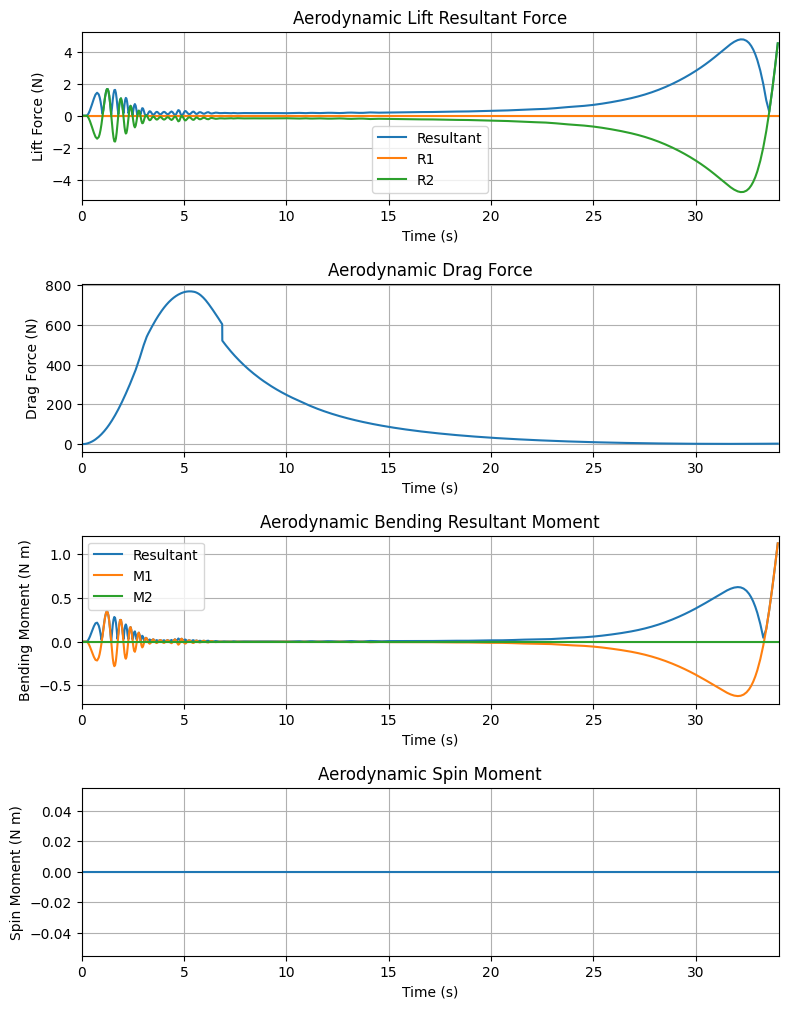



Trajectory Energy Plots



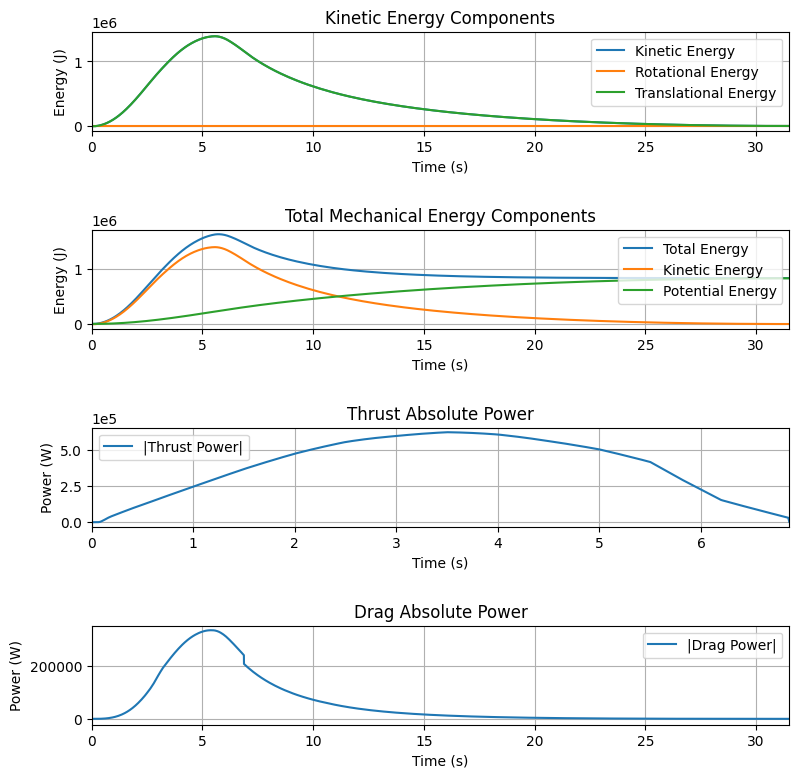



Trajectory Fluid Mechanics Plots



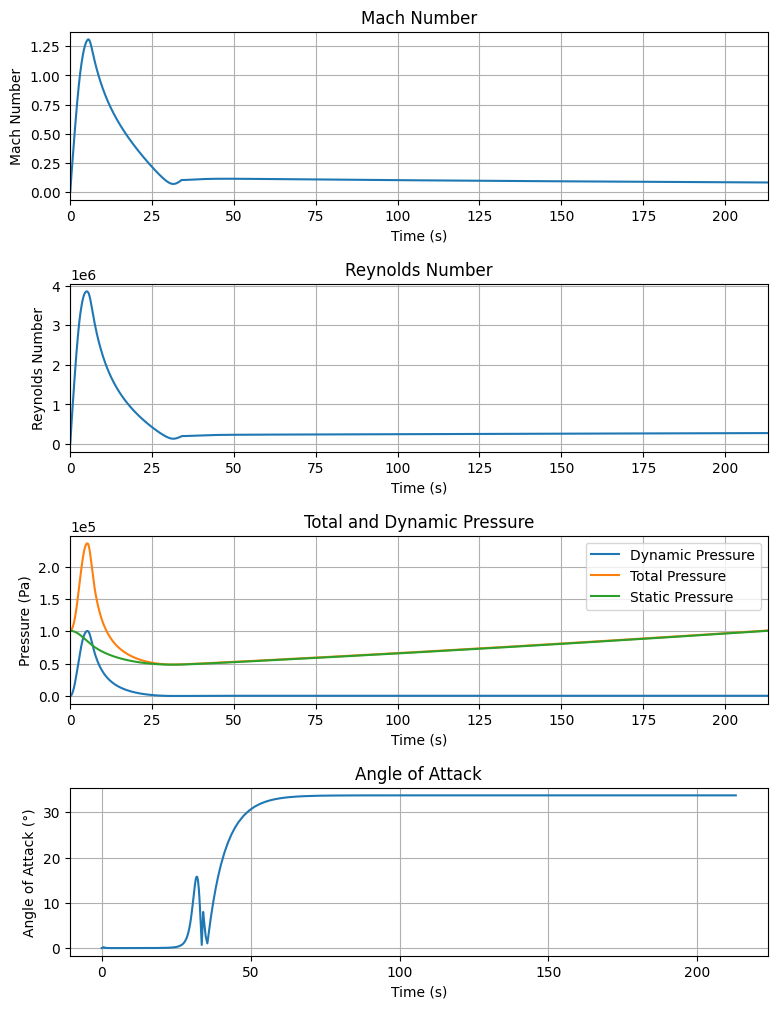



Trajectory Stability and Control Plots



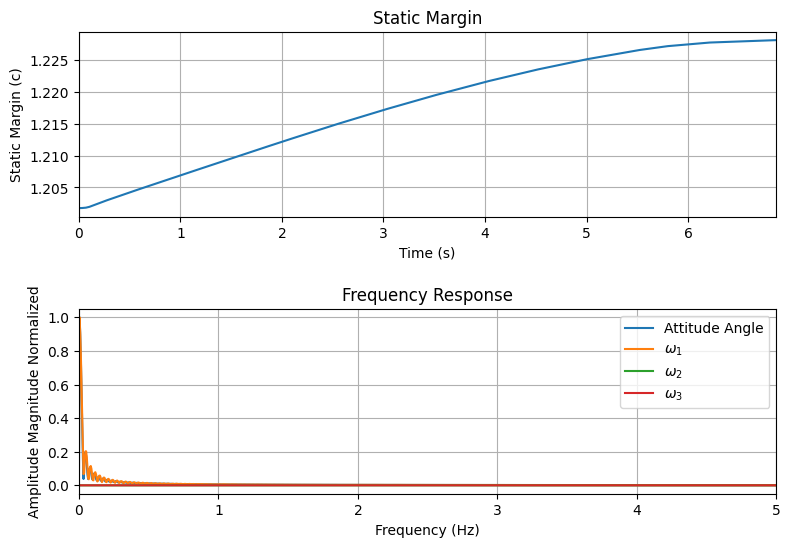

In [21]:
TestFlight = Flight(rocket=Nebula, environment=Env, inclination=85, heading=0)
TestFlight.allInfo()

In [22]:
finallongitude = longitude + TestFlight.xImpact * 0.00001
finallatitude = latitude + TestFlight.yImpact * 0.00001

print(f"http://maps.google.com/maps/dir/{finallatitude},{finallongitude}/{latitude},{longitude}")

http://maps.google.com/maps/dir/55.44426481291757,-5.68027/55.433159,-5.68027
